In [1]:
import warnings

import numpy as np
import scipy
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

from mapie._typing import NDArray
from mapie.metrics import regression_coverage_score
from mapie.regression import MapieQuantileRegressor, MapieRegressor

warnings.filterwarnings("ignore")

alpha = 0.1

# Generar _dataset_

In [2]:
def f(x: NDArray) -> NDArray:
    """Polynomial function used to generate one-dimensional data."""
    return np.array(5 * x + 5 * x**4 - 9 * x**2)


# Generate data
sigma = 0.1
n_samples = 10000
X = np.linspace(0, 1, n_samples)
y = f(X) + np.random.normal(0, sigma, n_samples)

# Train/validation/test split
X_train_cal, X_test, y_train_cal, y_test = train_test_split(
    X, y, test_size=1 / 10
)
X_train, X_cal, y_train, y_cal = train_test_split(
    X_train_cal, y_train_cal, test_size=1 / 9
)


# Entrenar modelo

In [5]:
# Train a MLPRegressor for MapieRegressor
est_mlp = MLPRegressor(activation="relu", random_state=1)
est_mlp.fit(X_train.reshape(-1, 1), y_train)

# Train LGBMRegressor models for MapieQuantileRegressor
list_estimators_cqr = []
for alpha_ in [alpha / 2, (1 - (alpha / 2)), 0.5]:
    estimator_ = LGBMRegressor(
        objective='quantile',
        alpha=alpha_,
    )
    estimator_.fit(X_train.reshape(-1, 1), y_train)
    list_estimators_cqr.append(estimator_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 1
[LightGBM] [Info] Start training from score 0.154943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 1
[LightGBM] [Info] Start training from score 0.834052
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 1
[LightGBM] [Info] Start training fro

In [6]:
# Calibrate uncertainties on calibration set
mapie = MapieRegressor(est_mlp, cv="prefit")
mapie.fit(X_cal.reshape(-1, 1), y_cal)

# Evaluate prediction and coverage level on testing set
y_pred, y_pis = mapie.predict(X_test.reshape(-1, 1), alpha=alpha)
coverage = regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])

# Calibrate uncertainties on calibration set
mapie_cqr = MapieQuantileRegressor(list_estimators_cqr, cv="prefit")
mapie_cqr.fit(X_cal.reshape(-1, 1), y_cal)

# Evaluate prediction and coverage level on testing set
y_pred_cqr, y_pis_cqr = mapie_cqr.predict(X_test.reshape(-1, 1))
coverage_cqr = regression_coverage_score(
    y_test,
    y_pis_cqr[:, 0, 0],
    y_pis_cqr[:, 1, 0]
)

# Calibrar

In [8]:
# Calibrate uncertainties on calibration set
mapie = MapieRegressor(est_mlp, cv="prefit")
mapie.fit(X_cal.reshape(-1, 1), y_cal)

# Evaluate prediction and coverage level on testing set
y_pred, y_pis = mapie.predict(X_test.reshape(-1, 1), alpha=alpha)
coverage = regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])

# Calibrate uncertainties on calibration set
mapie_cqr = MapieQuantileRegressor(list_estimators_cqr, cv="prefit")
mapie_cqr.fit(X_cal.reshape(-1, 1), y_cal)

# Evaluate prediction and coverage level on testing set
y_pred_cqr, y_pis_cqr = mapie_cqr.predict(X_test.reshape(-1, 1))
coverage_cqr = regression_coverage_score(
    y_test,
    y_pis_cqr[:, 0, 0],
    y_pis_cqr[:, 1, 0]
)


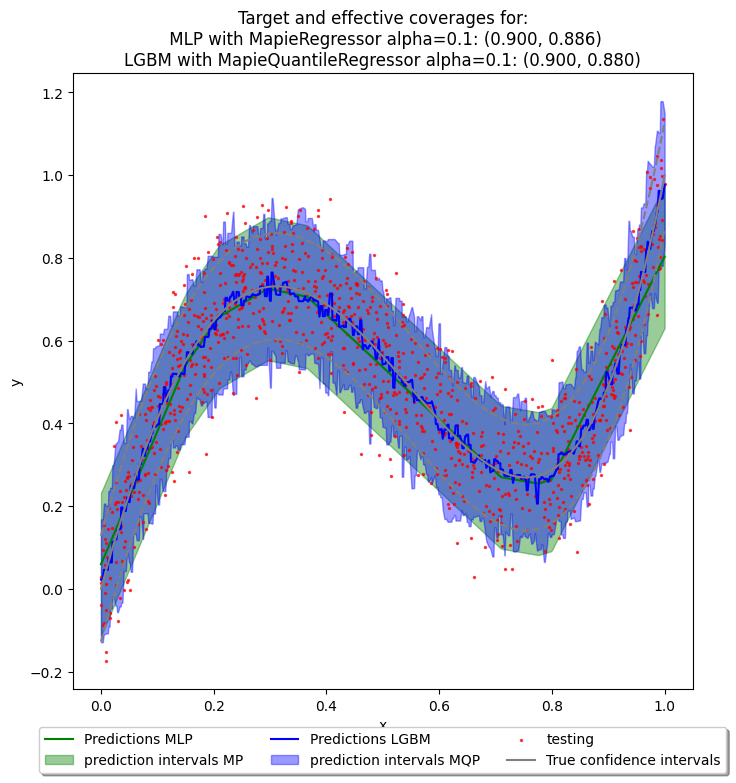

In [9]:
# Plot obtained prediction intervals on testing set
theoretical_semi_width = scipy.stats.norm.ppf(1 - alpha) * sigma
y_test_theoretical = f(X_test)
order = np.argsort(X_test)

plt.figure(figsize=(8, 8))
plt.plot(
    X_test[order],
    y_pred[order],
    label="Predictions MLP",
    color="green"
)
plt.fill_between(
    X_test[order],
    y_pis[:, 0, 0][order],
    y_pis[:, 1, 0][order],
    alpha=0.4,
    label="prediction intervals MP",
    color="green"
)
plt.plot(
    X_test[order],
    y_pred_cqr[order],
    label="Predictions LGBM",
    color="blue"
)
plt.fill_between(
    X_test[order],
    y_pis_cqr[:, 0, 0][order],
    y_pis_cqr[:, 1, 0][order],
    alpha=0.4,
    label="prediction intervals MQP",
    color="blue"
)
plt.title(
    f"Target and effective coverages for:\n "
    f"MLP with MapieRegressor alpha={alpha}: "
    + f"({1 - alpha:.3f}, {coverage:.3f})\n"
    f"LGBM with MapieQuantileRegressor alpha={alpha}: "
    + f"({1 - alpha:.3f}, {coverage_cqr:.3f})"
)
plt.scatter(X_test, y_test, color="red", alpha=0.7, label="testing", s=2)
plt.plot(
    X_test[order],
    y_test_theoretical[order],
    color="gray",
    label="True confidence intervals",
)
plt.plot(
    X_test[order],
    y_test_theoretical[order] - theoretical_semi_width,
    color="gray",
    ls="--",
)
plt.plot(
    X_test[order],
    y_test_theoretical[order] + theoretical_semi_width,
    color="gray",
    ls="--",
)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),
    fancybox=True,
    shadow=True,
    ncol=3
)
plt.show()

In [13]:
print(y_pis[0][1] - y_pis[0][0])
print(y_pis[1][1] - y_pis[1][0])

[0.34546814]
[0.34546814]


In [14]:
print(y_pis_cqr[0][1] - y_pis_cqr[0][0])
print(y_pis_cqr[1][1] - y_pis_cqr[1][0])

[0.29408655]
[0.33352843]


In [16]:
# Importar las librerías necesarias
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from mapie.regression import MapieQuantileRegressor, MapieRegressor

# 1. Cargar y preparar el conjunto de datos de California Housing
data = fetch_california_housing()
X, y = data.data, data.target

# Escalar los datos para mejorar el rendimiento de la red neuronal
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir el conjunto de datos en entrenamiento, calibración y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_cal, X_test, y_cal, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 2. Definir y entrenar la red neuronal
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Capa de salida para regresión
])

# Compilar y entrenar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# 3. Usar MAPIE para calcular los intervalos de predicción
mapie_regressor = MAPIERegressor(estimator=model, method="quantile", alpha=0.1)

# Ajustar MAPIE con el conjunto de calibración
mapie_regressor.fit(X_cal, y_cal)

# 4. Hacer predicciones con intervalos de confianza adaptativos
predicciones, intervalos_inferior, intervalos_superior = mapie_regressor.predict(X_test, alpha=0.1)

# 5. Mostrar algunos resultados
import pandas as pd

# Crear un DataFrame con las predicciones y los intervalos
resultados = pd.DataFrame({
    "Predicción": predicciones.flatten(),
    "Intervalo Inferior": intervalos_inferior.flatten(),
    "Intervalo Superior": intervalos_superior.flatten(),
    "Valor Real": y_test
})

# Mostrar las primeras filas de los resultados
print(resultados.head())

# Evaluar el modelo en el conjunto de prueba
mse_test = model.evaluate(X_test, y_test, verbose=0)
print(f"\nError cuadrático medio en el conjunto de prueba: {mse_test:.4f}")



I0000 00:00:1731587943.827088   14221 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4273 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/50


I0000 00:00:1731587944.776934   22536 service.cc:148] XLA service 0x7c6a58017b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731587944.777046   22536 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-14 13:39:04.793653: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731587944.852783   22536 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-14 13:39:04.891513: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


363/407 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 1.7982

I0000 00:00:1731587945.373643   22536 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7012 - val_loss: 0.4489
Epoch 2/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 0.4232 - val_loss: 0.3983
Epoch 3/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 0.3627 - val_loss: 0.3950
Epoch 4/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 0.3618 - val_loss: 0.3621
Epoch 5/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 0.3694 - val_loss: 0.3440
Epoch 6/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 0.3379 - val_loss: 0.3323
Epoch 7/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 0.3130 - val_loss: 0.3258
Epoch 8/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 0.3166 - val_loss: 0.3297
Epoch 9/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 0.3047 - val_loss: 0.3433
Epoch 10/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 0.3005 - val_loss: 0.3099
Epoch 11/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.3141 - val_loss: 0.3288
Epoch 12/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s

NameError: name 'MAPIERegressor' is not defined